In [49]:
import yfinance as yf
import pandas as pd
from scipy.optimize import minimize
import numpy as np
import datetime

In [50]:
tickers = ['SPY','BND','GLD','QQQ','VTI']

#tickers = ['HDFCBANK.NS','ZOMATO.NS', 'BHARTIARTL.NS','ITC.NS']

In [51]:
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=365)

In [52]:
close_price = yf.download(tickers, start=start_date, end=end_date)['Close']

[*********************100%***********************]  5 of 5 completed


In [53]:
log_return = np.log(close_price / close_price.shift(1))
log_return = log_return.dropna()

In [54]:
cov_matrix = log_return.cov()*252
print(cov_matrix)

Ticker       BND       GLD       QQQ       SPY       VTI
Ticker                                                  
BND     0.002782  0.001887  0.000569  0.000955  0.000988
GLD     0.001887  0.026029  0.011078  0.008885  0.008975
QQQ     0.000569  0.011078  0.060650  0.046060  0.045797
SPY     0.000955  0.008885  0.046060  0.037786  0.037694
VTI     0.000988  0.008975  0.045797  0.037694  0.037800


In [55]:
def standard_deviation(weight, cov_matrix):
  variance = weight.T @ cov_matrix @ weight
  return np.sqrt(variance)

In [56]:
def expected_return(weight, log_return):
  return np.sum(log_return.mean() * 252 * weight)

In [57]:
def sharp_ratio(weight, log_return, cov_matrix, risk_free_rate):
  return (expected_return(weight, log_return) - risk_free_rate) / standard_deviation(weight, cov_matrix)

In [58]:
!pip install fredapi

In [59]:
from fredapi import Fred

fred = Fred(api_key = "8ba31b9da271a539fe05b47630345a08")
ten_year_treasury_rate = fred.get_series_latest_release('GS10')/100

risk_free_rate = ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)

#risk_free_rate = 0.0644

0.042800000000000005


In [60]:
def negetive_sharp_ratio(weight, log_return, cov_matrix, risk_free_rate):
  return -sharp_ratio(weight, log_return, cov_matrix, risk_free_rate)

In [61]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.4) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

optimized_results = minimize(negetive_sharp_ratio, initial_weights, args=(log_return, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [62]:
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_return)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharp_ratio(optimal_weights, log_return, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
SPY: 0.4000
BND: 0.4000
GLD: 0.0000
QQQ: 0.2000
VTI: 0.0000
Expected Annual Return: 0.1587
Expected Volatility: 0.0911
Sharpe Ratio: 1.2723


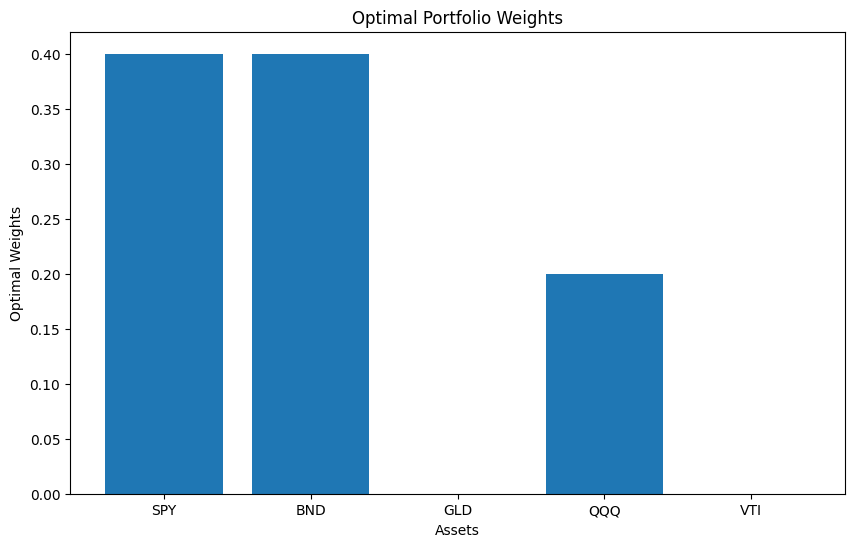

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()

In [64]:
# Monte Carlo Simulation of Portfolio Returns
num_simulations = 10000
time_horizon_years = 1

# Simulate correlated asset returns using multivariate normal distribution
simulated_asset_returns = np.random.multivariate_normal(
    mean=log_return.mean() * 252,  # annualized expected returns
    cov=cov_matrix * time_horizon_years,
    size=num_simulations
)

# Compute portfolio returns for each simulation
simulated_portfolio_returns = simulated_asset_returns @ optimal_weights

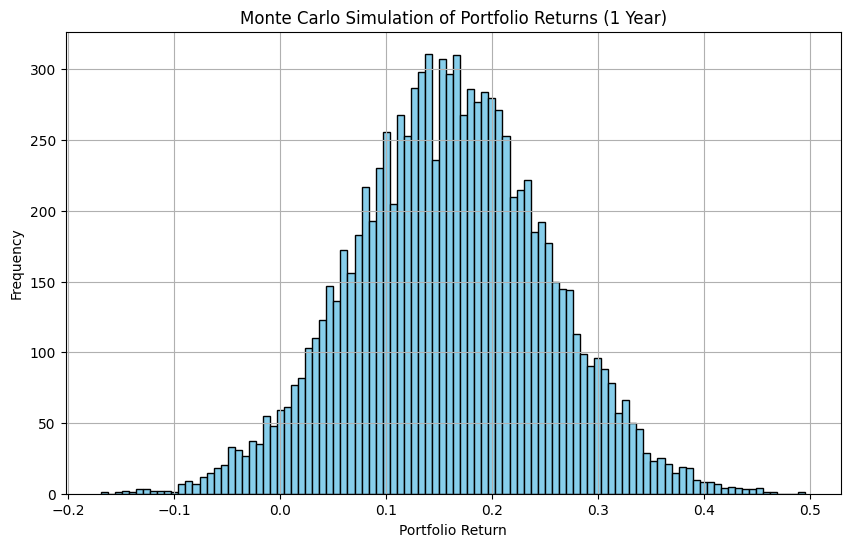

In [65]:
# Plot histogram of simulated returns
plt.figure(figsize=(10, 6))
plt.hist(simulated_portfolio_returns, bins=100, color='skyblue', edgecolor='black')
plt.title('Monte Carlo Simulation of Portfolio Returns (1 Year)')
plt.xlabel('Portfolio Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [66]:
# Value at Risk (95% confidence)
VaR_95 = np.percentile(simulated_portfolio_returns, 5)
print(f"Value at Risk (95% confidence): {VaR_95:.2%}")

Value at Risk (95% confidence): 1.16%


In [67]:
CVaR_95 = simulated_portfolio_returns[simulated_portfolio_returns <= VaR_95].mean()
print(f"Conditional VaR (CVaR 95%): {CVaR_95:.2%}")

Conditional VaR (CVaR 95%): -2.78%
